# ARIMAX (Autoregressive Integrated Moving Average with eXogenous variables) Model

This notebook demonstrates the implementation of the ARIMAX (Autoregressive Integrated Moving Average with eXogenous variables) Model.

ARIMAX is an extension of the ARIMA model that incorporates exogenous variables to improve forecasting. The model predicts the future values of a time series by combining:

- **Autoregression (AR)**: Models the relationship between the current value and its past values (lags).
- **Differencing (I)**: Removes trends or seasonality to make the time series stationary.
- **Moving Average (MA)**: Accounts for the dependency between an observation and a residual error from previous forecasts.
- **Exogenous Variables (X)**: Incorporates external factors that may influence the target variable.
This notebook demonstrates the implementation of the ARIMAX (ARIMA with Exogenous Variables) Model.

# Step 1 & 2: Loading Dataset and Defining Variables

### Step 1: Loading the Dataset
- I loaded the dataset from `'../datasets/master_dataset/master_dataset.xlsx'` using `pandas` and stored it in the variable `data`.

### Step 2: Defining Target and Exogenous Variables
- **Target Variable**: `Quantity`, which I want to forecast.
- **Exogenous Variables**: `Clicks` and `Impressions`, which may influence the target variable.
- These variables help the ARIMAX model combine historical data with external factors for accurate predictions.


In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Step 1: Load the dataset
data = pd.read_excel('../datasets/master_dataset/master_dataset.xlsx')

# Step 2: Define the main time series column and exogenous variables
target_column = "Quantity"  # The column we want to forecast
exogenous_columns = ["Clicks", "Impressions"]  # Exogenous variables

# Step 3: Preparing the Data

In this step, I prepared the data for ARIMAX analysis by cleaning and aligning the target and exogenous variables.

- **Removing Missing Values**:
  - I removed any missing values from the target column (`Quantity`) and the exogenous variables (`Clicks`, `Impressions`) using `.dropna()` to ensure clean data for analysis.

- **Aligning Data Lengths**:
  - I ensured that the target and exogenous variables had the same length by taking the minimum length of the two and slicing both datasets accordingly. This step avoids mismatched data during modeling.

- **Inspecting the Data**:
  - I displayed the first 5 rows of the target and exogenous variables to verify the data alignment and cleanliness.


In [2]:
# Step 3: Prepare the data
time_series = data[target_column].dropna()  # Remove missing values in the target column
exogenous_data = data[exogenous_columns].dropna()  # Drop missing values in exogenous variables

# Ensure the lengths of target and exogenous variables match
min_length = min(len(time_series), len(exogenous_data))
time_series = time_series.iloc[:min_length]
exogenous_data = exogenous_data.iloc[:min_length]

# Display first few rows of data
print(f"First 5 rows of the target column '{target_column}':\n", time_series.head())
print(f"First 5 rows of exogenous variables:\n", exogenous_data.head())

First 5 rows of the target column 'Quantity':
 0    14
1    10
2    13
3    22
4    33
Name: Quantity, dtype: int64
First 5 rows of exogenous variables:
    Clicks  Impressions
0     445          620
1     433          890
2     424          851
3     427          881
4     451          678


# Step 4: Checking Stationarity of the Target Column

- **Stationarity Test**:
  - I used the Augmented Dickey-Fuller (ADF) test to check if the target column (`Quantity`) was stationary.
  - The test outputs a **test statistic** and a **p-value**:
    - If the `p-value > 0.05`, the series is non-stationary, and differencing was applied to remove trends and make the series stationary.
    - If the `p-value <= 0.05`, the series is already stationary, and no further action was required.

- **Handling Non-Stationary Data**:
  - For non-stationary data, I calculated the differenced series using `.diff()` and removed the first row of exogenous data to align it with the differenced target column.

This step ensures the target column is stationary, which is critical for time series modeling with ARIMAX.


In [3]:
# Step 4: Check stationarity of the target column
adf_test = adfuller(time_series)
print(f"Dickey-Fuller Test Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

if adf_test[1] > 0.05:
    print(f"The target column '{target_column}' is non-stationary. Applying differencing...")
    time_series_diff = time_series.diff().dropna()  # Make the series stationary

    # Align exogenous data with differenced series
    exogenous_data = exogenous_data.iloc[1:].reset_index(drop=True)
else:
    print(f"The target column '{target_column}' is stationary.")
    time_series_diff = time_series

Dickey-Fuller Test Statistic: -4.445717448758575
p-value: 0.00024615679644112006
The target column 'Quantity' is stationary.


# Step 5: Fitting the ARIMAX Model

- **Setting Model Parameters**:
  - I defined the ARIMAX model parameters `(p, d, q)` as `(1, 1, 1)`:
    - `p`: The number of autoregressive terms.
    - `d`: The degree of differencing to make the series stationary.
    - `q`: The number of moving average terms.

- **Fitting the Model**:
  - I used the `SARIMAX` module from `statsmodels` to fit the ARIMAX model:
    - The differenced target series (`time_series_diff`) was used as the dependent variable.
    - The exogenous variables (`exogenous_data`) were included to capture external influences on the target variable.
  - The `.fit()` method was used to train the model.

This step ensures that the ARIMAX model is correctly fitted and ready for forecasting.

In [4]:
# Step 5: Fit the ARIMAX Model
p, d, q = 1, 1, 1  # ARIMAX model parameters
arimax_model = SARIMAX(time_series_diff, exog=exogenous_data, order=(p, d, q)).fit()

# Print the model summary
print("ARIMAX Model Summary:")
print(arimax_model.summary())

ARIMAX Model Summary:
                               SARIMAX Results                                
Dep. Variable:               Quantity   No. Observations:                  212
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -652.349
Date:                Wed, 27 Nov 2024   AIC                           1314.697
Time:                        00:29:30   BIC                           1331.457
Sample:                             0   HQIC                          1321.472
                                - 212                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Clicks          0.0146      0.004      3.579      0.000       0.007       0.023
Impressions     0.0012      0.001      1.322      0.186      -0.001       0.003
ar.L1           0.1365    

# Step 6: Making Predictions and Comparing Results

- **Generating Predictions**:
  - I used the `.predict()` method of the ARIMAX model to generate predictions for the target variable:
    - The range for predictions was set from `start=1` to `end=len(time_series_diff) - 1`.
    - The corresponding exogenous data (`exogenous_data.iloc[1:]`) was passed to align with the predictions.

- **Comparison of Actual vs. Predicted**:
  - I created a `pandas` DataFrame to combine the **actual** values of the target variable with the **predicted** values.
  - The first 5 rows of this comparison were displayed to inspect the results.

- **Visualizing the Comparison**:
  - I plotted the **Actual** vs. **Predicted** values to assess the model's performance:
    - The actual values were plotted in blue, while the predicted values were plotted in red (dashed line).
    - This visualization helped evaluate how closely the model predictions matched the actual data.

This step highlights the ARIMAX model's effectiveness in capturing patterns in the target variable and its relationship with exogenous factors.



First 5 rows of Actual vs Predicted for 'Quantity':
    Actual  Predicted
1      10  14.151810
2      13  11.613720
3      22  12.545884
4      33  16.060239
5      12  20.802290


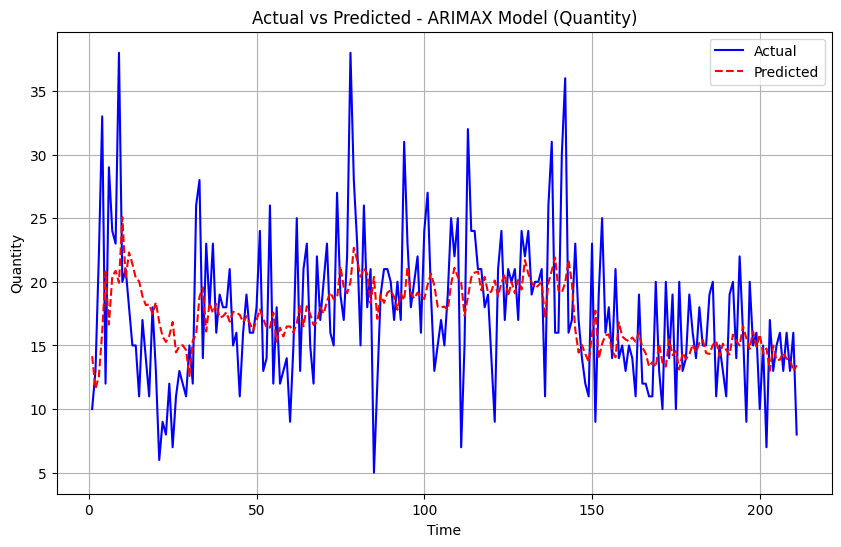

In [5]:
# Step 6: Make predictions
predictions = arimax_model.predict(start=1, end=len(time_series_diff) - 1, exog=exogenous_data.iloc[1:])

# Combine actual and predicted values for comparison
comparison = pd.DataFrame({
    "Actual": time_series_diff[1:].values,
    "Predicted": predictions
})

# Display first 5 rows of the comparison
print(f"\nFirst 5 rows of Actual vs Predicted for '{target_column}':\n", comparison.head())

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(comparison["Actual"], label="Actual", color="blue")
plt.plot(comparison["Predicted"], label="Predicted", color="red", linestyle="--")
plt.title(f"Actual vs Predicted - ARIMAX Model ({target_column})")
plt.xlabel("Time")
plt.ylabel(target_column)
plt.legend()
plt.grid()
plt.show()

# Step 7: Forecasting Future Values

- **Setting the Forecast Horizon**:
  - I defined the number of future steps to forecast as `5`, allowing the model to predict the next 5 values of the target variable.

- **Preparing Exogenous Data**:
  - I extracted the last 5 rows of the exogenous variables (`future_exog`) to provide the ARIMAX model with recent external factors for forecasting.

- **Generating Forecasts**:
  - I used the `.forecast()` method of the ARIMAX model to predict the next 5 values:
    - The exogenous variables (`future_exog`) were passed to incorporate external influences during forecasting.
  - The forecasted values were printed for review and interpretation.

This step uses the trained ARIMAX model to predict future values while leveraging exogenous factors to improve accuracy.


In [6]:
# Step 7: Forecast future values
forecast_steps = 5  # Number of steps to forecast
future_exog = exogenous_data.iloc[-forecast_steps:]  # Use recent exogenous data
forecast = arimax_model.forecast(steps=forecast_steps, exog=future_exog)

print(f"\nForecasted Values for '{target_column}':\n", forecast)


Forecasted Values for 'Quantity':
 212    13.408434
213    13.988237
214    13.595736
215    13.031066
216    12.954097
Name: predicted_mean, dtype: float64


# Step 8: Displaying Forecast Results

- **Creating the Forecast Index**:
  - I generated a range of indices to represent the future time points for the forecasted values:
    - The range started from the end of the original time series and extended for the defined `forecast_steps`.

- **Visualizing the Forecast**:
  - I plotted the original time series data (`time_series_diff`) and the forecasted values on the same graph:
    - The original series was plotted in blue, showing the historical behavior of the target variable.
    - The forecasted values were plotted in red with a dashed line to distinguish them clearly as predictions.
  - The plot includes:
    - A title to indicate the forecast results for the target variable.
    - Labels for the x-axis (`Time`) and y-axis (the target column).
    - A legend to differentiate between the original data and the forecasted values.

This step visually compares the model's forecast with the historical data, making it easier to interpret the future trends predicted by the ARIMAX model.


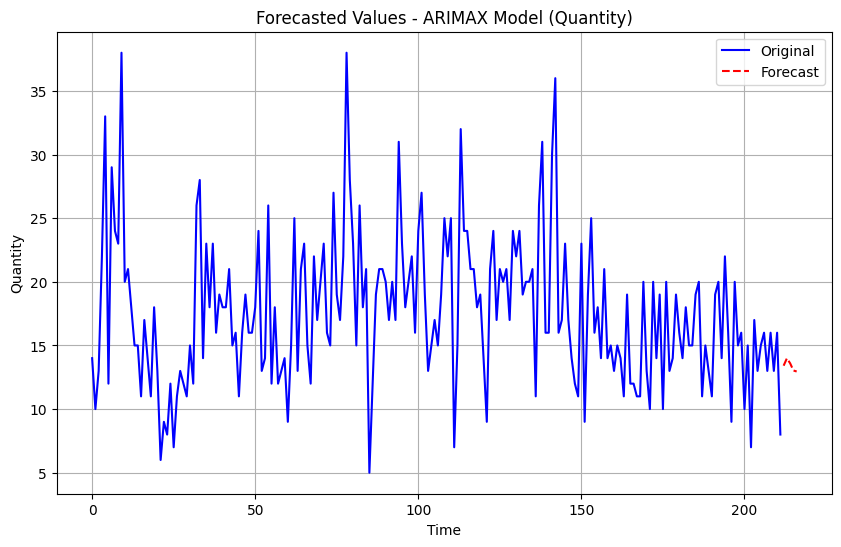

In [7]:
# Step 8: Display forecast results
future_index = range(len(time_series_diff), len(time_series_diff) + forecast_steps)
plt.figure(figsize=(10, 6))
plt.plot(time_series_diff, label="Original", color="blue")
plt.plot(future_index, forecast, label="Forecast", color="red", linestyle="--")
plt.title(f"Forecasted Values - ARIMAX Model ({target_column})")
plt.xlabel("Time")
plt.ylabel(target_column)
plt.legend()
plt.grid()
plt.show()